In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [14]:
# Для 3 классов
# Сейчас вход - точки плоскости (X,Y)

### ЕСЛИ СДЕЛАЮ МАКСИМАЛЬНО ДЛЯ ОБЩЕГО СЛУЧАЯ, ТО ОФИГЕННЫЙ ПРОЕКТ ДЛЯ ПОРТФОЛИО

class Layer():
    def __init__(self, is_hidden, layer_number, num_neurons=5, activation='linear'):
        self.num_neurons = num_neurons
        self.activation = activation
        
        self.output = np.zeros(num_neurons)
        self.is_hidden = is_hidden
        
        self.layer_number = layer_number
        
        self.all_funcs = {
            'tansig': lambda t: 2/(1+math.exp(-t))-1,
            'logsig': lambda t: 1/(1+math.exp(-t)),
            'linear': lambda t: t
        }
        
        # Для производных
        self.all_derivs = {
            'tansig': lambda t: 1 - t**2,
            'logsig': lambda t: t * (1 - t),
            'linear': 1
        }
    
    def acivation_func(self, x):
        try:
            return self.all_funcs[self.activation](x)
        except KeyError as e:
            raise ValueError('Undefined unit: {}'.format(e.args[0]))

###################################################################################################################
###################################################################################################################
###################################################################################################################
            
class MLNonLinear():
    def __init__(self, hidden_layer_sizes=(5,), hidden_activations=('linear',), output_activation='linear'):
        self.layers = []
        if len(hidden_layer_sizes) != len(hidden_activations):
            print("Number of layers and activation functions must agree!")
        
        self.layer_sizes = hidden_layer_sizes
        
        cnt = 1
        for i,j,k in zip(hidden_layer_sizes,hidden_activations, range(len(hidden_layer_sizes))):
            #if cnt == len(activations)
            tmp = Layer(num_neurons=i, activation=j, is_hidden=True, layer_number=k)
            self.layers.append(tmp)
        # отдельно выделить выходной слой - костыль пока
        self.layers.append(Layer(num_neurons=3, activation=output_activation, is_hidden=False, layer_number=k+1))
        
        self.weights = []
        i_pred = 2
        for i in hidden_layer_sizes: # + 3 выхода - если на скрытых 5 и 10, то в итоге имеем W1 5x2 + 5 смещений, W2 10x5 + 10 смещений, W3 3x10 + 3 смещения
            W = np.random.random((i, i_pred)) #Скользкое место, разберись с размерностями
            i_pred = i
            self.weights.append(W)
        self.weights.append(np.random.random((3, i_pred)))
        
        self.bias = []
        for i in hidden_layer_sizes:
            B = np.random.random(i) #столбец
            self.bias.append(B.T) #надеюсь он транспонирует
        self.bias.append(np.random.random(3).T)
        
        print(f"Generated weights: {self.weights},\nBias: {self.bias}\n")
        
    # Понять, как происходит проход, в зависимости от этого подавать все входы или по одному (сейчас один)
    # UPD 1: Астемир сказал, что через проход одного батча - несколько точек, но << len(dataset)
    def forward_pass(self, one_input, target):
        #for i in range(len(hidden_layer_sizes)+1):
        # кажется, что двойной цикл - это плохо
        #all_outputs = []
        current_layer_input = one_input
        for layer, layer_ind in zip(self.layers, range(len(self.layers))):
            # проверить, работают ли экспоненты и операции с массивами так, как нужно
            # надо ли запоминать выходы скрытых слоев? (сейчас да)
            
            #next_layer_input = [] # должен быть 5x1, поэтому сейчас транспонирование еще
            
            # Возможно глупый блок, так как у каждого нейрона в слое не может быть разной активационной функции
            ########################################################################################################################
            #for neuron_ind in range(layer.num_neurons):
            #    weighted_sum = np.dot(self.weights[layer_ind,neuron_ind], current_layer_input) + self.bias[layer_ind,neuron_ind]
            #    #weighted_sum = np.dot(self.weights[layer_ind], current_layer_input) + self.bias[layer_ind]
            #    neuron_ans = layer.activation_func(weighted_sum)
            #    
            #    next_layer_input.append(neuron_ans)
            #
            ########################################################################################################################
            
            
            # Добавить try - catch на размерность
            weighted_sum = np.dot(self.weights[layer_ind], current_layer_input) + self.bias[layer_ind]
            layer_ans = layer.activation_func(weighted_sum)
            
            #current_layer_input = np.array(next_layer_input)
            current_layer_input = np.array(layer_ans)
            
            #all_outputs.append(current_layer_input)
            layer.output = current_layer_input
            
        output = current_layer_input
        error = 1./2 * ((target-output)**2).sum() # E_total
        return output, error #, all_outputs
    
    # Мб функцию correct_weights, которая принимает метод корректировки (аналогично с инициализацией функции активации - через словарь или как-то так)
    # чекнуть "switch python"
    # куда-то засунуть batch_size, возможно в fit
    
    def backwards_pass(self, output, target, error, method='backprop', learning_rate=0.05): # или backprop сделать, потом еще по варианту 2 штуки
        # FACT 1: Rprop обновляет после 1 эпохи, то есть прохождения всего датасета!
        
        # Надо хранить результаты выходов нейронов???? (видимо, да) all_outputs
        # UPD 1: Можно хранить как аттрибута класса Layer
        
        # Вычисление ошибки
        #error = 1./2 * ((target-output)**2).sum() # E_total
        
        # Заполнение дельт весов "прошлых шагов" нулями в начале работы
        i_pred = 2
        
        for i in self.layer_sizes: # + 3 выхода - если на скрытых 5 и 10, то в итоге имеем W1 5x2 + 5 смещений, W2 10x5 + 10 смещений, W3 3x10 + 3 смещения
            dW = np.zeros((i, i_pred)) #Скользкое место, разберись с размерностями
            i_pred = i
            delta_weight.append(W)
        delta_weight.append(np.zeros((3, i_pred)))
        #delta_weight = np.zeros(self.weights.shape)
        
        delta_weights = []
        
        # Дельты
        # пока для выходного:
        deltas = []
        #for layer in self.layers:
        #for layer, ind in zip(self.layers, range(len(all_outputs))):
        for layer in reversed(self.layers): # обратный порядок же
            #for i in range(len(output)):
            #for i in range(all_outputs.shape[-1]):
            #for i in range(len(all_outputs[ind])):
            delta = []
            if not(layer.is_hidden):
                
                for out, ind in zip(layer.ouput, len(layer.output)):
                    #delta = (out - target[ind]) * layer.all_derivs[layer.activation](out)
                    delta.append((out - target[ind]) * layer.all_derivs[layer.activation](out))
                deltas.append(np.array(delta))
            else:
                for out, ind in zip(layer.ouput, len(layer.output)):
                    #delta = (out - target[ind]) * layer.all_derivs[layer.activation](out)
                    summ = 0
                    #for k in range(len(deltas[len(self.layers)-1 - layer.layer_number])):
                    #for k in range(len(deltas[len(self.layers) - 1 - layer.layer_number - 1])):
                    #    ####################### Очень кользкое место с индексами
                    #    #summ += deltas[len(self.layers)-1 - layer.layer_number - 1,k] * self.weights[len(self.layers)-1 - layer.layer_number, k, ind]
                    #    summ += deltas[len(self.layers)-1 - layer.layer_number - 1,k] * self.weights[len(self.layers)-1 - layer.layer_number, k, ind]
                    #    #delta = layer.all_derivs[layer.activation](out) * 
                    #    #deltas.append(delta)
                    
                    tmp = self.weights[layer.layer_number+1].T
                    res = np.dot(deltas[len(self.layers)-1 - layer.layer_number - 1], tmp[ind])
                    print(f"Delta_j (must be 1-dim) : {res}\n")
                    #delta = layer.all_derivs[layer.activation](out) * res
                    delta.append(layer.all_derivs[layer.activation](out) * res)
                    
                    #delta.append(layer.all_derivs[layer.activation](out) * summ)
                deltas.append(np.array(delta))
                
            delta_weight_intermediate = delta_weight[layer.layer_number] + learning_rate * \
                                            np.dot(deltas[len(self.layers)-1 - layer.layer_number - 1], layer.output)
            
            delta_weights.append(delta_weight_intermediate)
        
            # тут еще append()
            # потом пересчет всех весов
        
        for layer in self.layers: # обратный порядок же
            self.weights[layer.layer_number] -= delta_weights[len(self.layers) - layer.layer_number - 1]
        #### ТУТ ЯВНО ТРАБЛЫ В ИНДЕКСАХ.............

    #def rprop(self):
    #    pass
    
    # Сделать что-то с батчем!
    
    def fit(self, input_, target_, batch_size=5, method='backprop', learning_rate=0.05):
        #цикл
            #feedforward
            #correct_weights
        epochs = 0
        ans = []
        errs = []
        
        # Размер батча может не делиться нацело на объем - предусмотреть
        # Пока через if сделаю
        while(epochs*batch_size < len(input_)):
            for i in range(batch_size):
                if i+epochs*batch_size < len(input_):
                    o, e = forward_pass(input_[i+epochs*batch_size], target_)
                    ans.append(o)
                    errs.append(e)
            
                else:
                    break
            backwards_pass(o, target_[i+epochs*batch_size], e, method=method, learning_rate=learning_rate)
            epochs += 1
        # Добавить еще ошибки по эпохам для графиков и тд
        return ans, errs, epochs
    
    # Supervised_learning - предусмотреть без учителя
    def predict(self, input_, target_):
        ans = []
        errs = []
        for i in range(len(input_)):
            o, e, _ = forward_pass(input_[i], target_)
            ans.append(o)
            errs.append(e)
        return ans, errs

In [15]:
a1 = 0.3
b1 = 0.3
alpha1 = 0
x01 = 0
y01 = 0.2

p2 = 0.5
alpha2 = 0
x02 = -0.5
y02 = 0

p3 = 1
alpha3 = 0
x03 = -0.8
y03 = 0

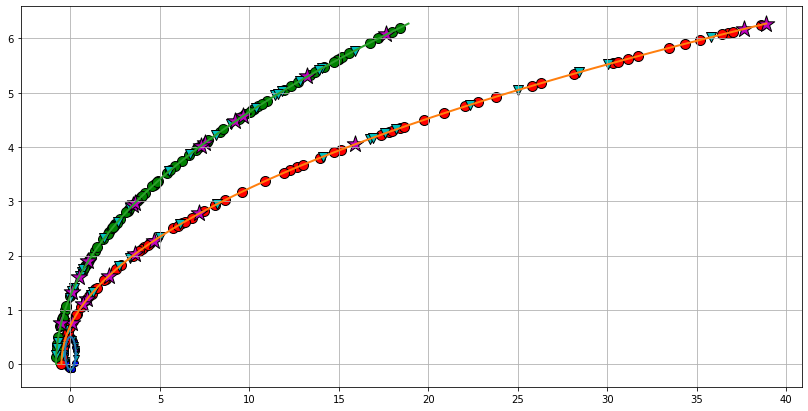

In [16]:
t = np.arange(0, 2*math.pi, 0.025)
x1 = [x01 + a1*math.cos(t)*math.cos(alpha1) + b1*math.sin(t)*math.sin(alpha1) for t in t]
y1 = [y01 - a1*math.cos(t)*math.sin(alpha1) + b1*math.sin(t)*math.cos(alpha1) for t in t]

x2 = [x02 + t**2/(2*p2)*math.cos(alpha2) - t*math.sin(alpha2) for t in t]
y2 = [y02 + t**2/(2*p2)*math.sin(alpha2) + t*math.cos(alpha2) for t in t]

x3 = [x03 + t**2/(2*p3)*math.cos(alpha3) - t*math.sin(alpha3) for t in t]
y3 = [y03 + t**2/(2*p3)*math.sin(alpha3) + t*math.cos(alpha3) for t in t]

line1 = np.random.permutation(len(t))[:60]
line2 = np.random.permutation(len(t))[:100]
line3 = np.random.permutation(len(t))[:120]
#print(line1)

xp1 = []
xp2 = []
xp3 = []
for i in line1:
    xp1.append(x1[i])
for i in line2:
    xp2.append(x2[i])
for i in line3:
    xp3.append(x3[i])
    
yp1 = []
yp2 = []
yp3 = []
for i in line1:
    yp1.append(y1[i])
for i in line2:
    yp2.append(y2[i])
for i in line3:
    yp3.append(y3[i])

class1 = np.random.permutation(np.array(list(zip(xp1,yp1))))

#train1 = np.random.permutation(class1)[:int(len(line1)*0.7)]
train1 = class1[:int(len(line1)*0.7)]
#valid1 = np.random.permutation(class1)[:int(len(line1)*0.2)]
valid1 = class1[int(len(line1)*0.7):int(len(line1)*0.7)+int(len(line1)*0.2)]
test1 = class1[int(len(line1)*0.7)+int(len(line1)*0.2):]
#print(train1)
#train1_ind = len(line1)*0.7
train1x = np.array(train1[:,0])
train1y = np.array(train1[:,1])
valid1x = np.array(valid1[:,0])
valid1y = np.array(valid1[:,1])
test1x = np.array(test1[:,0])
test1y = np.array(test1[:,1])

class2 = np.random.permutation(np.array(list(zip(xp2,yp2))))
train2 = class2[:int(len(line2)*0.7)]
valid2 = class2[int(len(line2)*0.7):int(len(line2)*0.7)+int(len(line2)*0.2)]
test2 = class2[int(len(line2)*0.7)+int(len(line2)*0.2):]
train2x = np.array(train2[:,0])
train2y = np.array(train2[:,1])
valid2x = np.array(valid2[:,0])
valid2y = np.array(valid2[:,1])
test2x = np.array(test2[:,0])
test2y = np.array(test2[:,1])

class3 = np.random.permutation(np.array(list(zip(xp3,yp3))))
train3 = class3[:int(len(line3)*0.7)]
valid3 = class3[int(len(line3)*0.7):int(len(line3)*0.7)+int(len(line3)*0.2)]
test3 = class3[int(len(line3)*0.7)+int(len(line3)*0.2):]
train3x = np.array(train3[:,0])
train3y = np.array(train3[:,1])
valid3x = np.array(valid3[:,0])
valid3y = np.array(valid3[:,1])
test3x = np.array(test3[:,0])
test3y = np.array(test3[:,1])

train1t = [[0, 0, 1] for i in train1x]
train2t = [[0, 1, 0] for i in train2x]
train3t = [[1, 0, 0] for i in train3x]
valid1t = [[0, 0, 1] for i in valid1x]
valid2t = [[0, 1, 0] for i in valid2x]
valid3t = [[1, 0, 0] for i in valid3x]
test1t = [[0, 0, 1] for i in test1x]
test2t = [[0, 1, 0] for i in test2x]
test3t = [[1, 0, 0] for i in test3x]

trainX = [train1x, train2x, train3x]
trainY = [train1y, train2y, train3y]
validX = [valid1x, valid2x, valid3x]
validY = [valid1y, valid2y, valid3y]
testX = [test1x, test2x, test3x]
testY = [test1y, test2y, test3y]

#for i in train1:
#    train1x.append()
#print(len(class1), len(train1), len(valid1), len(test1))
plt.figure(figsize=(14,7))
plt.plot(x1, y1, linewidth=2)
plt.plot(x2, y2, linewidth=2)
plt.plot(x3, y3, linewidth=2)
#plt.scatter(xp1, yp1, linewidth=1, edgecolors='k')
plt.scatter(train1x, train1y, linewidth=1, c = 'b', edgecolors='k')
plt.scatter(valid1x, valid1y, linewidth=1, c='c', edgecolors='k', marker='v')
plt.scatter(test1x, test1y, linewidth=1, c='m', edgecolors='k', marker='*')

plt.scatter(train2x, train2y, linewidth=1, c = 'r', s = 100, edgecolors='k')
plt.scatter(valid2x, valid2y, linewidth=1, c='c', edgecolors='k', s = 100, marker='v')
plt.scatter(test2x, test2y, linewidth=1, c='m', edgecolors='k', s = 300, marker='*')

plt.scatter(train3x, train3y, linewidth=1, c = 'g', s = 100, edgecolors='k')
plt.scatter(valid3x, valid3y, linewidth=1, c='c', edgecolors='k', s = 100, marker='v')
plt.scatter(test3x, test3y, linewidth=1, c='m', edgecolors='k', s = 300, marker='*')

#plt.scatter(xp2, yp2, linewidth=1, edgecolors='k')
#plt.scatter(xp3, yp3, linewidth=1, edgecolors='k')
#plt.xlim([-1, 1])
#plt.ylim([-0.15, 1.25])
#plt.xlim([-0.3, 0.3])
#plt.ylim([-0.1, 0.5])
plt.grid()

In [17]:
attempt1 = MLNonLinear((5,10), hidden_activations=('linear','linear'))

Generated weights: [array([[0.74904337, 0.37665496],
       [0.57163637, 0.54532307],
       [0.70684284, 0.16060911],
       [0.80876674, 0.38536267],
       [0.17941099, 0.24899177]]), array([[0.20784907, 0.7550689 , 0.70643769, 0.88657719, 0.95262838],
       [0.34545269, 0.18526727, 0.02242796, 0.74247591, 0.60233058],
       [0.13238893, 0.0436413 , 0.68464352, 0.46000124, 0.44470747],
       [0.07729552, 0.28120658, 0.20137218, 0.02597257, 0.65173394],
       [0.59751454, 0.81304845, 0.40732835, 0.47043968, 0.08509386],
       [0.06757386, 0.94457504, 0.4073228 , 0.4393588 , 0.84775008],
       [0.72111404, 0.62625777, 0.66614402, 0.81661706, 0.79234794],
       [0.90128244, 0.25563536, 0.47256322, 0.04135833, 0.51342918],
       [0.68629136, 0.34156689, 0.79531261, 0.28707026, 0.68718982],
       [0.96354097, 0.57124109, 0.52400245, 0.34825807, 0.93013763]]), array([[0.14723806, 0.77455703, 0.93326018, 0.23819944, 0.8843348 ,
        0.77431632, 0.45425636, 0.77926676, 0.1213431

In [6]:
abc = [[0, 0, 1] for i in train1x]
print(abc)

[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]


In [5]:
temp = np.random.random((5,3))
print(temp.shape[0])
temp_t = temp.T
print(temp_t.shape)

5
(3, 5)


In [22]:
np.random.random((5, 5))

array([[0.53399866, 0.00896738, 0.98818645, 0.06763196, 0.2293857 ],
       [0.28877559, 0.4573424 , 0.7378609 , 0.88830768, 0.38145901],
       [0.27044907, 0.71889935, 0.01561975, 0.13082085, 0.64011058],
       [0.57944686, 0.36643506, 0.50036343, 0.97396392, 0.34097524],
       [0.40182968, 0.63775062, 0.04436164, 0.02042696, 0.31804687]])

In [32]:
hd = (5,10)
td = ('act','bad')
for i,j in zip(hd,td):
    print(i,j)

5 act
10 bad


In [7]:
a = np.array([5, 4, 1])
b = np.array([-1, 2, 9])
print(a-b)
print((a-b)**2)
print(((a-b)**2).sum())

[ 6  2 -8]
[36  4 64]
104


In [11]:
lst = [[0,1,2], [3,4], [5,5,5,5,5]]
#nplst = np.array(lst)
lengh = len(lst)
#print(len(lst))

for i in range(lengh):
    for j in lst[i]:
        print(j)

0
1
2
3
4
5
5
5
5
5
